<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/hourly_Ensamble_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## install finrl library
!pip install git+https://github.com/meti-94/FinRL.git -q
!pip install setuptools==58.2.0 -q

     |████████████████████████████████| 234 kB 8.3 MB/s 
     |████████████████████████████████| 176 kB 45.8 MB/s 
     |████████████████████████████████| 59.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 36.0 MB/s 
     |████████████████████████████████| 124 kB 51.0 MB/s 
     |████████████████████████████████| 150 kB 44.1 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 2.4 MB 31.3 MB/s 
     |████████████████████████████████| 153 kB 42.9 MB/s 
     |████████████████████████████████| 195 kB 46.8 MB/s 
     |████████████████████████████████| 90.8 MB 298 bytes/s 
     |████████████████████████████████| 448 kB 47.0 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |████████████████████████████████| 271 kB 48.4 MB/s 
     |████████████████████████████████| 3.6 MB 33.2 MB/s 
     |██████████

In [2]:
from finrl.apps import config
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
from datetime import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
def read_data(path):
    hist = pd.read_csv(path, parse_dates=True)
    hist = hist[hist.Timestamp>=1388521800]
    hist['date'] = hist['Timestamp'].apply(lambda item:datetime.fromtimestamp(item))
    hist.set_index('date', inplace=True)
    hist.dropna(inplace=True)
    return hist

def resampling(hist, timeframe='1min'):
    ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)':'sum'
    }
    df = hist.resample(timeframe, origin='end_day').apply(ohlc)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'Open':'open', 'High':'high', 'Close':'close', 'Low':'low', 'Volume_(BTC)':'volume'}, inplace=True)
    df['date'] = df['date'].astype(str)
    df['tic'] = ['BTC' for _ in range(len(df))]
    df['day'] = [i%24 for i in range(len(df))]
    return df   
hist = read_data('/content/drive/MyDrive/kaggle_dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
hist = hist['2020-10-01' :'2021-03-30']
hist = resampling(hist, timeframe='H')
df = hist

In [20]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=False,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [21]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(set(processed['date'].astype(str).to_list()))
combination = list(itertools.product(list_date,list_ticker))
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)
# print(list_ticker, list_date[:10], combination[:10])

In [22]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2020-10-01 00:00:00,BTC,10780.83,10790.79,10780.83,10783.78,2.946380,0,0.000000,10803.974953,10774.135047,100.000000,66.666667,100.000000,10783.780000,10783.780000,0.0
1,2020-10-01 01:00:00,BTC,10782.36,10829.84,10782.36,10794.33,115.146021,1,0.236699,10803.974953,10774.135047,100.000000,66.666667,100.000000,10789.055000,10789.055000,0.0
2,2020-10-01 02:00:00,BTC,10794.49,10859.51,10788.64,10856.39,113.437229,2,2.226078,10889.964252,10733.035748,100.000000,100.000000,100.000000,10811.500000,10811.500000,0.0
3,2020-10-01 03:00:00,BTC,10848.99,10852.50,10813.57,10827.19,52.452711,3,2.022076,10881.381593,10749.463407,70.519857,60.290273,100.000000,10815.422500,10815.422500,0.0
4,2020-10-01 04:00:00,BTC,10826.37,10829.86,10793.07,10798.06,37.593177,4,0.709505,10871.145579,10752.754421,54.069863,-20.122910,47.726868,10811.950000,10811.950000,0.0
5,2020-10-01 05:00:00,BTC,10802.10,10830.21,10798.04,10806.94,132.228363,5,0.286850,10864.218923,10758.011077,57.217038,-1.263610,47.975032,10811.115000,10811.115000,0.0
6,2020-10-01 06:00:00,BTC,10801.85,10836.29,10795.24,10830.93,75.540391,6,1.097643,10864.684109,10763.207320,64.093124,37.564229,52.189852,10813.945714,10813.945714,0.0
7,2020-10-01 07:00:00,BTC,10833.24,10849.63,10817.03,10833.70,109.257311,7,1.755397,10865.422462,10767.407538,64.769460,82.557200,59.823841,10816.415000,10816.415000,0.0
8,2020-10-01 08:00:00,BTC,10833.62,10940.22,10806.50,10865.57,163.238005,8,3.765357,10878.227246,10765.526087,71.221277,177.525707,81.392143,10821.876667,10821.876667,0.0
9,2020-10-01 09:00:00,BTC,10871.22,10929.88,10816.81,10883.13,801.023146,9,6.040891,10893.754226,10762.249774,73.941348,149.296145,81.392143,10828.002000,10828.002000,0.0


In [23]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
4335,2021-03-30 15:00:00,BTC,58932.33,59039.61,58615.12,58910.90,128.390431,15,551.744505,59501.042940,56500.061060,61.303323,135.587261,28.079353,57967.518333,56872.005000,0.008427
4336,2021-03-30 16:00:00,BTC,58904.18,58921.10,58430.09,58661.86,209.161336,16,521.769272,59570.035304,56525.535696,59.468522,98.368261,21.325479,57990.972667,56913.885833,0.302037
4337,2021-03-30 17:00:00,BTC,58661.86,58841.28,58445.17,58717.03,96.402327,17,496.739340,59617.659692,56631.216308,59.744634,90.314149,21.325479,58012.405000,56953.794167,0.012902
4338,2021-03-30 18:00:00,BTC,58735.91,58885.00,58673.96,58747.94,61.725871,18,473.933903,59671.761990,56707.195010,59.902950,94.796664,22.429897,58041.872000,56994.350667,0.003513
4339,2021-03-30 19:00:00,BTC,58773.82,59144.94,58773.82,58849.28,198.557621,19,458.749541,59737.220028,56760.599972,60.430744,104.344750,28.783724,58066.568000,57042.739667,0.044748
4340,2021-03-30 20:00:00,BTC,58851.42,59135.00,58733.00,59037.79,104.111136,20,456.662881,59819.267061,56815.273939,61.408259,99.766095,27.036958,58101.457333,57089.263000,0.163110
4341,2021-03-30 21:00:00,BTC,59014.42,59032.73,58402.82,58591.06,125.871531,21,414.187317,59823.809943,56924.306057,57.901628,62.010524,13.702231,58116.505667,57126.520167,0.958498
4342,2021-03-30 22:00:00,BTC,58592.54,58872.27,58570.57,58762.56,48.198945,22,389.869569,59807.521063,57091.784937,58.835166,63.703513,13.702231,58156.877667,57170.390167,0.139002
4343,2021-03-30 23:00:00,BTC,58787.45,58941.34,58642.58,58657.09,67.727386,23,357.960683,59746.824941,57298.832059,58.016687,60.388228,15.814539,58192.812333,57213.845000,0.054222
4344,2021-03-31 00:00:00,BTC,58651.94,58770.38,58567.11,58760.59,78.047558,0,337.137930,59619.899090,57596.703910,58.601331,51.800440,12.595492,58221.545667,57264.520167,0.049842


In [25]:
train = data_split(processed_full, '2020-10-01','2021-02-15')
trade = data_split(processed_full, '2021-02-15','2021-03-30')
print(len(train))
print(len(trade))

3288
1032


In [26]:
 train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
3283,2021-02-14 19:00:00,BTC,48632.32,48860.17,48435.90,48708.86,112.548076,19,365.647606,49913.036533,47094.918467,55.923441,54.238459,15.271498,48012.799667,47748.499833,0.001952
3284,2021-02-14 20:00:00,BTC,48723.96,48952.55,48512.58,48649.24,111.881141,20,332.315404,49849.171980,47301.463020,55.495899,53.118562,17.652301,48069.023667,47769.863000,0.040330
3285,2021-02-14 21:00:00,BTC,48649.24,49044.45,48649.24,48918.93,100.634212,21,323.927093,49849.515724,47422.512276,57.033045,62.201358,20.041541,48133.443000,47799.232167,0.161430
3286,2021-02-14 22:00:00,BTC,48882.18,49083.94,48763.56,48817.98,124.107348,22,305.610586,49804.198882,47592.945118,56.280320,59.902175,21.093160,48187.855000,47821.903000,0.082896
3287,2021-02-14 23:00:00,BTC,48844.56,49329.23,48781.60,49038.84,159.178747,23,305.395766,49738.537144,47810.660856,57.548375,69.379879,27.430464,48249.305667,47846.946833,0.094628


In [27]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2020-10-01 00:00:00,BTC,10780.83,10790.79,10780.83,10783.78,2.946380,0,0.000000,10803.974953,10774.135047,100.000000,66.666667,100.000000,10783.7800,10783.7800,0.0
1,2020-10-01 01:00:00,BTC,10782.36,10829.84,10782.36,10794.33,115.146021,1,0.236699,10803.974953,10774.135047,100.000000,66.666667,100.000000,10789.0550,10789.0550,0.0
2,2020-10-01 02:00:00,BTC,10794.49,10859.51,10788.64,10856.39,113.437229,2,2.226078,10889.964252,10733.035748,100.000000,100.000000,100.000000,10811.5000,10811.5000,0.0
3,2020-10-01 03:00:00,BTC,10848.99,10852.50,10813.57,10827.19,52.452711,3,2.022076,10881.381593,10749.463407,70.519857,60.290273,100.000000,10815.4225,10815.4225,0.0
4,2020-10-01 04:00:00,BTC,10826.37,10829.86,10793.07,10798.06,37.593177,4,0.709505,10871.145579,10752.754421,54.069863,-20.122910,47.726868,10811.9500,10811.9500,0.0


In [28]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [29]:
env_kwargs = {
    "hmax": 10, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.0001,
    "sell_cost_pct": 0.0001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-3,
    "print_verbosity": 5
    
}



In [30]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

train_start = '2020-10-01'
train_end = '2021-01-15'
val_test_start = '2021-01-15'
val_test_end = '2021-02-15'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [31]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {
                 'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {
                 'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [32]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  12.894185994970073
======Model training from:  2020-10-01 to  2021-01-15 00:00:00
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_2
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.44    |
|    explained_variance | 0.000386 |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 6.86     |
|    reward             | -0.86418 |
|    std                | 1.02     |
|    value_loss         | 11.7     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 133      

In [39]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-15 00:00:00,2021-01-17 15:00:00,DDPG,-0.265212,-0.438555,0.0
1,189,2021-01-17 15:00:00,2021-01-20 06:00:00,A2C,0.060971,-0.102066,0.043432
2,252,2021-01-20 06:00:00,2021-01-22 21:00:00,PPO,-0.020065,0.043446,-0.097428
3,315,2021-01-22 21:00:00,2021-01-25 12:00:00,A2C,0.010706,-0.084772,-0.009934
4,378,2021-01-25 12:00:00,2021-01-28 03:00:00,DDPG,-0.166653,-0.124318,0.009905
5,441,2021-01-28 03:00:00,2021-01-30 18:00:00,DDPG,0.134164,0.067721,0.134164
6,504,2021-01-30 18:00:00,2021-02-02 09:00:00,PPO,-0.002413,0.161261,0.0
7,567,2021-02-02 09:00:00,2021-02-05 00:00:00,A2C,0.381482,0.137215,0.252126
8,630,2021-02-05 00:00:00,2021-02-07 15:00:00,PPO,0.125757,0.354628,0.163342
9,693,2021-02-07 15:00:00,2021-02-10 06:00:00,A2C,0.317772,0.108873,0.0


In [40]:
unique_trade_date = processed[(processed.date > '2021-01-15')&(processed.date <= '2021-02-15')].date.unique()

In [41]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.3779952407243318


In [42]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,100000.0,2021-01-17 15:00:00,NaN,2021-01-17 15:00:00
1,100000.0,2021-01-17 16:00:00,0.0,2021-01-17 16:00:00
2,100000.0,2021-01-17 17:00:00,0.0,2021-01-17 17:00:00
3,100000.0,2021-01-17 18:00:00,0.0,2021-01-17 18:00:00
4,100000.0,2021-01-17 19:00:00,0.0,2021-01-17 19:00:00


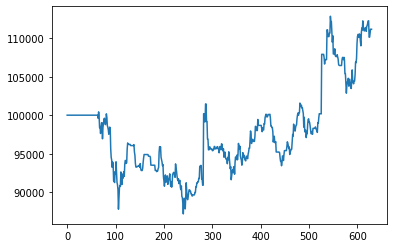

In [43]:
%matplotlib inline
df_account_value.account_value.plot()

In [45]:
print("==============Get Backtest Results===========")
now = datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.043204
Cumulative returns     0.111534
Annual volatility      0.136018
Sharpe ratio           0.377995
Calmar ratio           0.327562
Stability              0.303329
Max drawdown          -0.131894
Omega ratio            1.093711
Sortino ratio          0.664049
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.073332
Daily value at risk   -0.016933
dtype: float64


In [47]:
#baseline stats

print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="BTC", 
        start = '2021-01-15',
        end = '2021-02-15')

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (20, 8)
Annual return         -0.002913
Cumulative returns    -0.000231
Annual volatility      0.007027
Sharpe ratio          -0.433601
Calmar ratio          -1.765899
Stability              0.143669
Max drawdown          -0.001649
Omega ratio            0.931322
Sortino ratio         -0.647096
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.306907
Daily value at risk   -0.000897
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (20, 8)


Start date,2021-01-17
End date,2021-02-12
Total months,30
,Backtest
Annual return,4.32%
Cumulative returns,11.153%
Annual volatility,13.602%
Sharpe ratio,0.38
Calmar ratio,0.33
Stability,0.30
Max drawdown,-13.189%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.19,2021-01-20,2021-01-27,2021-01-29,8
1,9.70,2021-01-29,2021-01-31,2021-02-06,6
2,8.85,2021-02-09,2021-02-10,NaT,NaN
3,4.41,2021-02-06,2021-02-07,2021-02-08,0
4,1.17,2021-02-08,2021-02-08,2021-02-09,1


Stress Events,mean,min,max
New Normal,0.02%,-2.79%,10.22%


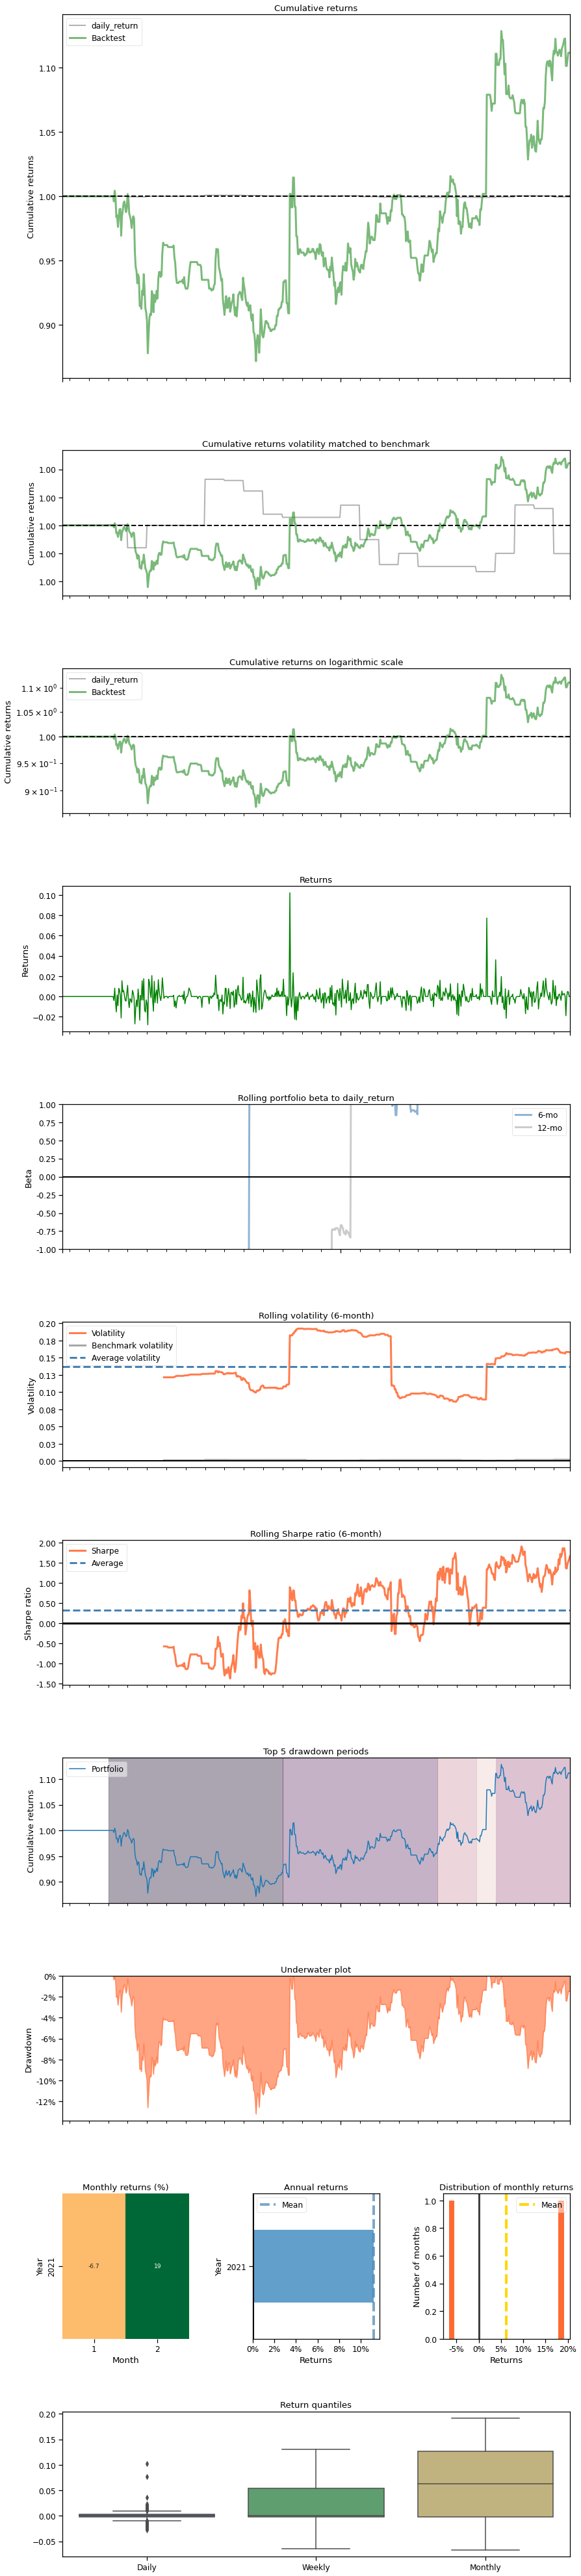

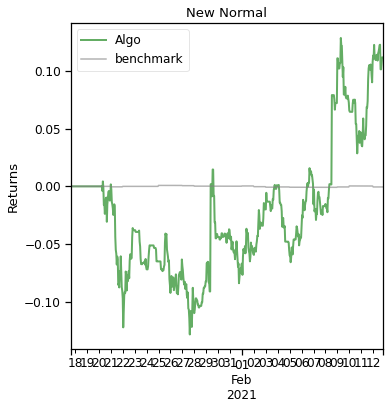

In [48]:


print("==============Compare to DJIA===========")
%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = "BTC", 
             baseline_start = '2021-01-15',
             baseline_end = '2021-02-15')

